##### Master Degree in Computer Science and Data Science for Economics

# Example of a naive search engine

### Alfio Ferrara

In [1]:
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer
import pymongo
import pandas as pd

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## A toy example

In [4]:
from mongodb_scripts.textgen import ConditionalTextGenerator
import numpy as np 

In [5]:
vocab = ["sunny", "cloudy", "rain", "snow", "windy"]
gen = ConditionalTextGenerator(vocab, order=2, mix=0.9)

gen.base_unigram = gen._normalize_dist(gen.base_unigram)

# Rules: P(next | context)
gen.set_rule(("sunny",),  {"sunny":0.55, "cloudy":0.30, "windy":0.10, "rain":0.04, "snow":0.01})
gen.set_rule(("cloudy",), {"cloudy":0.45, "rain":0.25, "sunny":0.20, "windy":0.08, "snow":0.02})
gen.set_rule(("rain",),   {"rain":0.50, "cloudy":0.35, "windy":0.10, "sunny":0.04, "snow":0.01})
gen.set_rule(("snow",),   {"snow":0.50, "cloudy":0.35, "windy":0.10, "sunny":0.03, "rain":0.02})
gen.set_rule(("windy",),  {"windy":0.30, "cloudy":0.35, "sunny":0.15, "rain":0.15, "snow":0.05})
gen.set_rule(("sunny","windy"),  {"sunny":0.50, "cloudy":0.25, "windy":0.20, "rain":0.05})
gen.set_rule(("cloudy","windy"), {"cloudy":0.45, "rain":0.30, "windy":0.15, "sunny":0.10})
gen.set_rule(("windy","sunny"),  {"sunny":0.55, "cloudy":0.20, "windy":0.20, "rain":0.05})
gen.set_rule(("windy","rain"),   {"rain":0.55, "cloudy":0.25, "windy":0.15, "sunny":0.05})

docs = [" ".join(gen.generate(x, start_context=np.random.choice(vocab))) for x in np.random.randint(7, 50, size=200)]

In [6]:
docs[0]

'rain rain rain rain cloudy windy rain rain cloudy sunny windy cloudy cloudy cloudy sunny cloudy sunny snow cloudy cloudy snow cloudy'

### Indexing

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:

wtokenizer = lambda x: x.split()
vectorizer = CountVectorizer(tokenizer=wtokenizer, token_pattern=None)
W = vectorizer.fit_transform(docs).toarray()
Wdf = pd.DataFrame(W, columns=vectorizer.get_feature_names_out())

Wdf.head()

,cloudy,rain,snow,sunny,windy
0,9,6,2,3,2
1,12,9,4,13,6
2,8,8,0,14,6
3,11,4,4,6,3
4,13,9,4,14,6


### Vector space

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

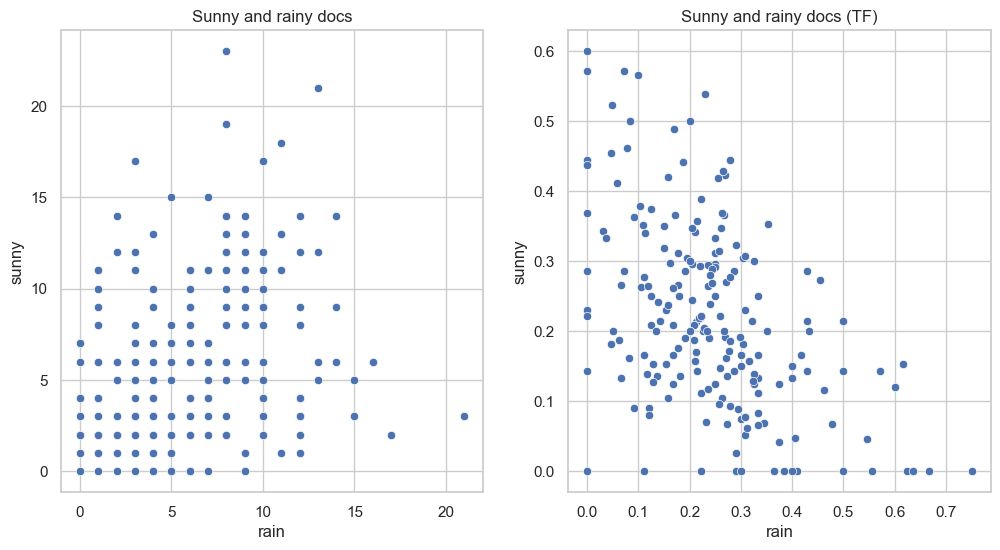

In [10]:
sns.set(style="whitegrid") 

TFW = (Wdf.T / Wdf.sum(axis=1)).T

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
sns.scatterplot(data=Wdf, x="rain", y="sunny", ax=ax[0])
sns.scatterplot(data=TFW, x="rain", y="sunny", ax=ax[1])
ax[0].set_title("Sunny and rainy docs")
ax[0].set_xlabel("rain")
ax[0].set_ylabel("sunny")
ax[1].set_title("Sunny and rainy docs (TF)")
ax[1].set_xlabel("rain")
ax[1].set_ylabel("sunny")
plt.show()

### Visualize docs per main type

In [11]:
from collections import Counter
from sklearn.manifold import TSNE

c:\Users\cola0\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\cola0\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\cola0\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cola0\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\cola0\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProce

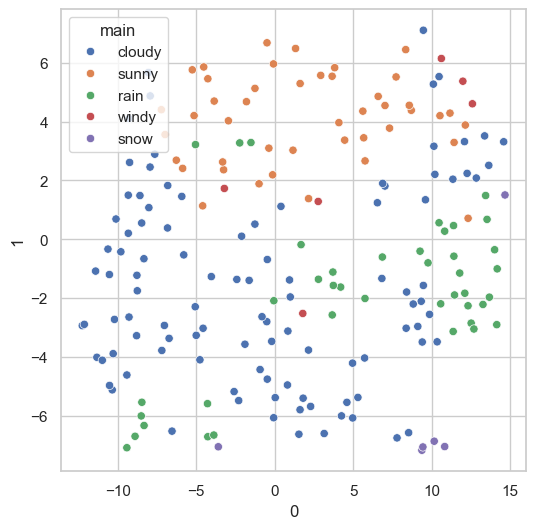

In [12]:
labels = [vocab.index(Counter(doc.split()).most_common(1)[0][0]) for doc in docs]
W2 = pd.DataFrame(TSNE(n_components=2).fit_transform(Wdf))
W2['main'] = [vocab[i] for i in labels]
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=W2, x=0, y=1, hue='main', ax=ax)
plt.show()


## Real data

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [14]:
db = pymongo.MongoClient()['climate']
collection = db['evidences']
docs = []
for evidence in collection.find():
    claim = evidence['claim']
    article = evidence['article']
    text = evidence['evidence']
    docs.append(". ".join([claim, article, text]))

## Indexing

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
def bert_tokenize(text):
    return tokenizer.tokenize(text)

In [17]:
vectorizer = CountVectorizer(tokenizer=bert_tokenize, token_pattern=None)
X = vectorizer.fit_transform(docs).toarray()

In [18]:
Xdf = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

In [19]:
Xdf 

,!,"""",##0,##00,##0s,##1,##10,##11,##12,##13,...,′,″,€,₹,⇌,−,∩,∪,≡,⋅
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
docs[0]

'Global warming is driving polar bears toward extinction. Extinction risk from global warming. "Recent Research Shows Human Activity Driving Earth Towards Global Extinction Event".'

In [21]:
Xdf.loc[0].sort_values(ascending=False).head(10)

.             3
global        3
extinction    3
warming       2
"             2
driving       2
toward        1
bears         1
polar         1
recent        1
Name: 0, dtype: int64

## Search

In [22]:
query = "Extinction of animals"
q = vectorizer.transform([query]).toarray().reshape(1, -1)
q 

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
sigma = cosine_similarity(q, X)
sigma.shape 

(1, 15350)

In [25]:
query_answer = pd.Series(sigma[0], index=range(len(docs)))
A = query_answer.sort_values(ascending=False).head(10)

In [26]:
from nltk.tokenize import sent_tokenize

In [27]:
def pretty_print(doc):
    return "\n".join([s for s in sent_tokenize(doc)])

In [28]:
for i, s in A.items():
    print(f"Document {i} with similarity {s}")
    print(pretty_print(docs[i]))
    print()

Document 11683 with similarity 0.4407318961869527
Polar bears are in danger of extinction as well as many other species.. Holocene extinction.
There is widespread consensus among scientists that human activity is accelerating the extinction of many animal species through the destruction of habitats, the consumption of animals as resources, and the elimination of species that humans view as threats or competitors.

Document 4008 with similarity 0.4407318961869527
Polar bears are in danger of extinction as well as many other species.. Holocene extinction.
There is widespread consensus among scientists that human activity is accelerating the extinction of many animal species through the destruction of habitats, the consumption of animals as resources, and the elimination of species that humans view as threats or competitors.

Document 3272 with similarity 0.41464421443136473
Each year sees the disappearance of thousands of plant and animal species which we will never know, which our child

## IDF

In [29]:
from collections import defaultdict

In [30]:
DF = defaultdict(lambda: 0)
for doc in docs:
    tokens = set(bert_tokenize(doc))
    for token in tokens:
        DF[token] += 1
DF = pd.Series(DF)

In [29]:
DF.sort_values(ascending=False)
IDF = len(docs) / DF 
IDF.sort_values(ascending=True)


.               1.000000
the             1.082663
,               1.197348
of              1.269434
and             1.475962
                ...     
attending    7675.000000
selling      7675.000000
pact         7675.000000
accession    7675.000000
##upt        7675.000000
Length: 11188, dtype: float64

In [30]:
import matplotlib.pyplot as plt
import numpy as np

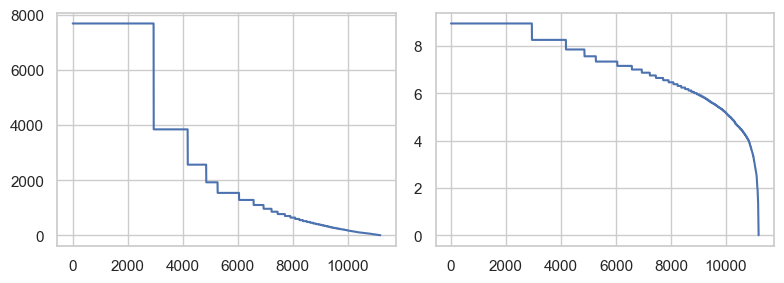

In [31]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
ax[0].plot(IDF.sort_values(ascending=False).values)
ax[1].plot(np.log(IDF.sort_values(ascending=False).values))
plt.tight_layout()
plt.show()

## TFIDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
tfv = TfidfVectorizer(tokenizer=bert_tokenize, token_pattern=None)

In [35]:
Xtfidf = tfv.fit_transform(docs).toarray()
TFIDF = pd.DataFrame(Xtfidf, columns=tfv.get_feature_names_out())

In [36]:
TFIDF

,!,"""",##0,##00,##0s,##1,##10,##11,##12,##13,...,′,″,€,₹,⇌,−,∩,∪,≡,⋅
0,0.0,0.176270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.198048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7670,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7671,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7672,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7673,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
TFIDF.loc[0].sort_values(ascending=False).head(10)

extinction    0.588030
driving       0.419246
toward        0.226610
towards       0.217113
bears         0.213513
global        0.211675
risk          0.190221
event         0.180604
"             0.176270
shows         0.172170
Name: 0, dtype: float64